In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import r2_score

pd.options.display.float_format = '{:.2f}'.format
country_label = 'MCO'

def plot_model_performance(model, X_train, X_test, y_train, y_test):
    regr = model.fit(X_train, y_train)
    print('train score: {}'.format(regr.score(X_train, y_train)))
    predictions = regr.predict(X_train)
    sns.regplot(x = y_train, y = predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    print('test score: {}'.format(regr.score(X_test, y_test)))
    predictions = regr.predict(X_test)
    sns.regplot(x = y_test, y = predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

def parse_dic(x, field):
    try:
        return x[field]
    except:
        return np.nan

# en esta clase se configura el modo debug para no exceder 
# el valor offset = 1000 ya que no se esta usando un access token de developer
# De esta manera solo trabajamos con una muestra por categoria de maximo 1000 datapoints

class mercadolibreAPI: 

    def __init__(self, country_label, debug = True):
        self.debug = debug
        self.ml_url = 'http://api.mercadolibre.com/sites/{}/search?q='.format(country_label)
 
    def request_get(self, url):
        #if (self.debug): print("Procesando url: ", url)
        try:
            return requests.get(url).json()
        except:
            return None

    def transform(self, ):
        self.item_df['number_pictures'] =  self.item_df['pictures'].apply(lambda x: len(x))
        self.item_df['days'] =  self.item_df['date_created'].apply(
            lambda x: datetime.datetime.today()-datetime.datetime.strptime(x.split('T')[0], '%Y-%m-%d')
            )
        self.item_df['days'] =  self.item_df['days'].apply(lambda x: x.days)

    def get_items_info(self,):
        self.objects = []
        if self.item_list is not None:
            for id in self.item_list:
                item_url = 'http://api.mercadolibre.com/items/{}'.format(id)
                jsdata = self.request_get(item_url)
                if (jsdata is not None): 
                        self.objects.append(jsdata)
            self.item_df = pd.DataFrame(self.objects)
 
    def search_items(self, query, ):
        self.items = []
        url = self.ml_url + query
        print("Buscando: " + url)
        if (self.debug):
            paginators = 20
        else:
            paginators = round(self.request_get(url)['paging']['total']/50)+1
        for offset in range(0,paginators):
            url = self.ml_url + query + '&offset=' + str(offset*50)
            jsdata = self.request_get(url)
            if (jsdata is not None):
                try:  
                    self.items = self.items + jsdata['results']
                except:
                    print(jsdata)

        self.df = pd.DataFrame(self.items)
        self.item_list = ml.df['id'].values
        self.get_items_info()
        

# Extracción de los datos e identificación de features

Aquí se extrae un muestra de datos con la keyword `smart TV`. De esto se obtiene un sample de 1000 datapoints donde el dataframe `ml.item_df` contiene los atributos de las publicaciones como columnas así como la variable objetivo `sold_quantity`. 

In [2]:
ml = mercadolibreAPI(country_label)
ml.search_items('smart%20Tv')
ml.transform()
# aqui solo se muestran algunos features en el dataframe, 
ml.item_df[['id', 'title', 'days', 'price', 'number_pictures', 'sold_quantity']]

Buscando: http://api.mercadolibre.com/sites/MCO/search?q=smart%20Tv


,id,title,days,price,number_pictures,sold_quantity
0,MCO557060514,Televisor Hyundai 40 Pulgadas Fhd Smart - Hyle...,200,919900,10,250
1,MCO568756830,Televisor Full Hd Smart Tv 2020 Un43t5300,98,1119900,2,50
2,MCO558421368,Televisor Hyundai 50 Pulgadas 4k Smart Diseño ...,182,1349900,4,100
3,MCO566829981,Televisor Hyundai 32 Smart Hd Borderless - Hyl...,112,659900,7,150
4,MCO557062580,Televisor Hyundai 55 Pulgadas 4k Uhd Smart - H...,200,1549900,5,50
...,...,...,...,...,...,...
994,MCO529767190,Cubierta De Tv Para Exteriores - Pulgadas Le...,422,177900,3,0
995,MCO537074704,Vizio 40pLG Clase (39.5pLG Diag.) 4k Hdr Smart Tv,366,2709000,6,0
996,MCO538142075,Tcl 32s325 32 PLG 720p Roku Smart Tv Led (2019...,358,958000,4,0
997,MCO562946967,Sony Xbr55x900f 55inch 4k Ultra Hd Smart Led T...,142,9548990,8,0


Inicialmente se considera buscar correlaciones con variables más sencillas:. 
* `days`: antiguedad de la publicación.
* `price`: precio del item
* `number_pictures`: numero de imagenes en la publicación.

Pero la conclusión es que la muestra de datos usada no evidencia candidato viable a predictor para un modelo.

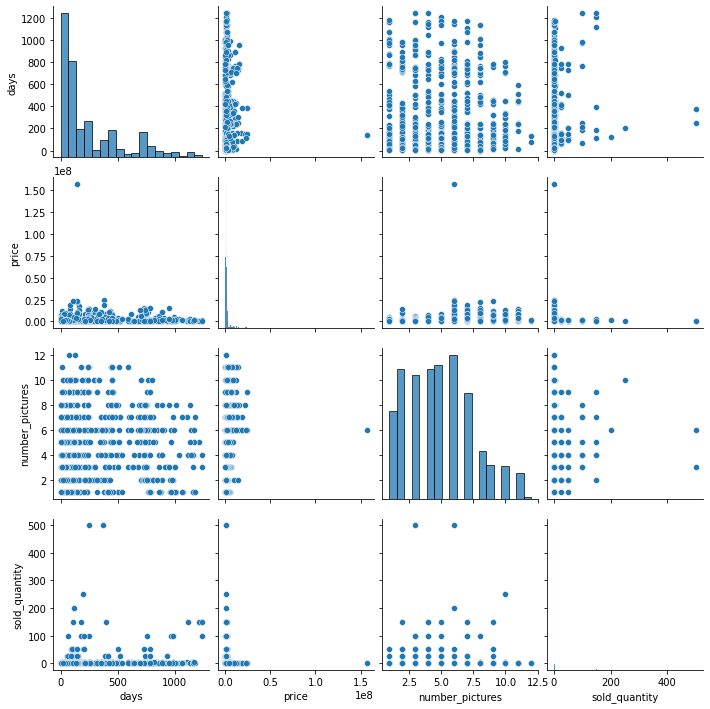

In [3]:
sns.pairplot(ml.item_df[['days', 'price', 'number_pictures', 'sold_quantity']])

# Atributos de las publicaciones como atributos

Dado que la tarea era un modelo de regresión con atributos que tipicamente son categoricos, se consideró una transformación a features dummy que resultaron en vectores de features de más de 1000 componentes. 

## Fully sparse predictors with dummy transformation.

In [4]:
df = pd.DataFrame()
Y = []
for element, result in zip(ml.item_df['attributes'].values, ml.item_df['sold_quantity'].values):
    if len(element)>0:
        Y.append(result)
        tt = pd.DataFrame(element)[['id', 'value_name']].set_index('id').T
        df = pd.concat([tt, df])

X = df[['BRAND', 'COLOR', 'DISPLAY_SIZE', 'DISPLAY_TYPE', 
    'IS_3D', 'IS_CURVED', 'IS_PORTABLE', 'IS_SMART', 'OPERATIVE_SYSTEM', 'RESOLUTION_TYPE',
    'WITH_HDMI', 'WITH_HDR', 'WITH_USB', 'WITH_VGA', 'WITH_WI_FI',
    'BRIGHTNESS', 'CONTRAST_RATIO', 'LINE', 'RESPONSE_TIME',
    'STORAGE_CAPACITY', 'ACCESSORIES_INCLUDED', 
    'DEPTH', 'HDMI_PORTS_NUMBER', 'HEIGHT', 'MAX_RESOLUTION',
    'MAX_SPEAKERS_POWER', 'SOUND_MODES', 'SPEAKERS_NUMBER',
    'USB_PORTS_NUMBER', 'WEIGHT', 'WIDTH', 'WITH_AUTO_POWER_OFF',
    'WITH_BLUETOOTH', 'WITH_WEB_BROWSER', 'PROCESSOR_CORES_NUMBER',
    'WITH_ETHERNET', 'WITH_INTEGRATED_VOICE_COMMAND', 'WITH_NETFLIX',
    'WITH_SCREEN_SHARE_FUNCTION', 'WITH_YOUTUBE', 'DISPLAY_TECHNOLOGY']]
X = pd.get_dummies(data = X, drop_first=True).values
y = ml.item_df['sold_quantity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44, test_size = 0.1)
print(X.shape)

(999, 1112)


Se utilizan dos modelos a saber de Scikit: 

* `RandomForestRegressor`
* `MLPRegressor`

Los cuales logran hacer un match con la data de entrenamiento (mejor en el caso del MLP) pero en ambos casos con un fuerte overfit (ver graficos con la data de test). 

train score: 0.837009063823871


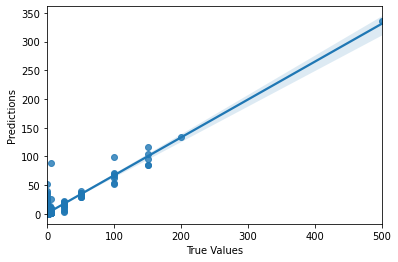

test score: -0.047007520016805415


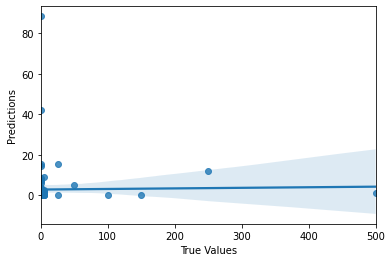

In [5]:
model = RandomForestRegressor(max_depth=40, random_state=0)
plot_model_performance(model, X_train, X_test, y_train, y_test)

train score: 0.8636125903525641


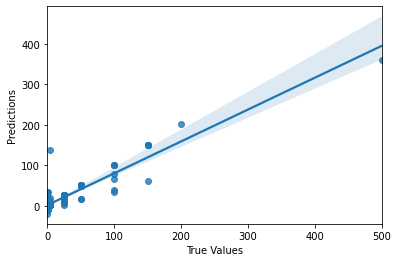

test score: -0.27265476680498657


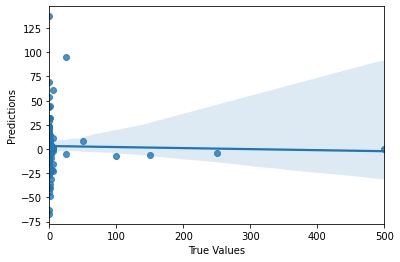

In [6]:
model = MLPRegressor(random_state=1, max_iter=10000)
plot_model_performance(model, X_train, X_test, y_train, y_test)

## PCA predictors 

En ciertos casos la codificacion por variables dummy expande demasiado el espacio de features y se pueden presentar colinealidades innecesarias. Se consideró ajustar este efecto aplicando una reducción de dimensionalidad con PCA a un punto donde se podia conservar al menos mas del 95% de la varianza total de los datos. 

In [7]:
pca = PCA(n_components=400, svd_solver='full')
pca.fit(X)
print('explained variance: ', np.sum(pca.explained_variance_ratio_))
Xpca = pca.transform(X)
y = y = ml.item_df['sold_quantity'].values
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, random_state=44, test_size = 0.1)
print('array shape: ', Xpca.shape)

explained variance:  0.9834036265610421
array shape:  (999, 400)


Aplicando a estos nuevos features los mismos dos modelos del paso anterior, se logra mejores ajustes pero eso no elimina el overfit.

train score: 0.8126013572965829


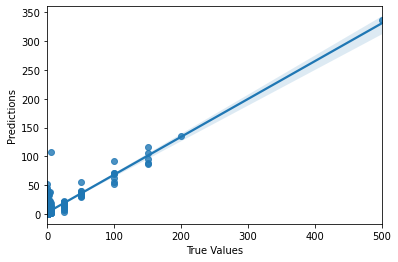

test score: -0.09529004814677


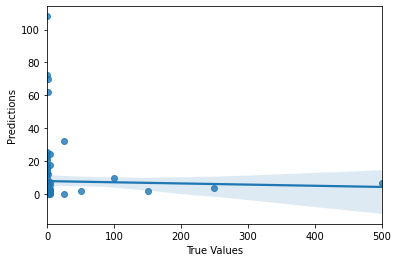

In [8]:
model = RandomForestRegressor(max_depth=40, random_state=0)
plot_model_performance(model, X_train, X_test, y_train, y_test)

train score: 0.98513794689116


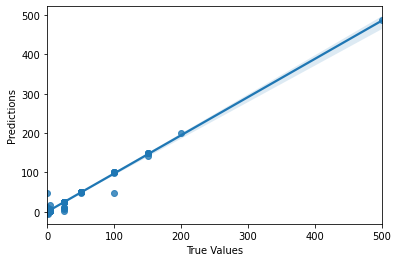

test score: -0.36354633009241866


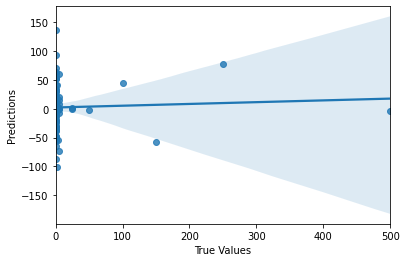

In [9]:
model = MLPRegressor(random_state=1, max_iter=10000)
plot_model_performance(model, X_train, X_test, y_train, y_test)

## DNN regressor over PCA predictors

Luego de los experimentos anteriores los cuales se escogieron porque fueron los unicos modelos que resultaban en un R2 score decente para la data de training, se considera un modelo de DNN con tensorflow, para explorar modelos con mayor versatilidad y donde posiblemente ciertos parametros permitan controlar mejor el overfit. 

In [10]:
def build_model():
  tf.compat.v1.reset_default_graph()
  model = keras.Sequential([ 
            layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.5), 
            layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.5),
            layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  #plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

Con la arquitectura de NN considerada anteriormente usando la API sequential de Keras, se entrena un modelo por 2000 epochs. Dentro de la arquitectura se consideran las siguientes reglas para atenuar overfit: 

* uso de Dropout entre capas
* uso de regularizadores en las capas

estos tips se usan por recomendacion de la documentacion de Tensorflow. 
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

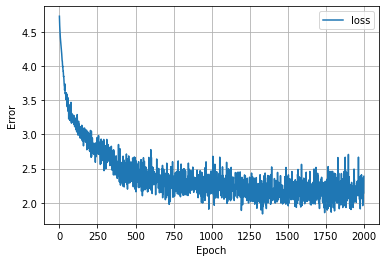

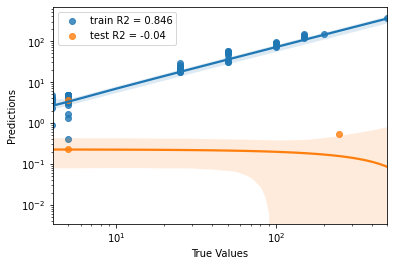

In [11]:
model = build_model()
history = model.fit(X_train, y_train, epochs=2000, verbose = 0)
plot_loss(history)
predictions_train = model.predict(X_train)
sns.regplot(x = y_train, y = predictions_train, 
            label='train R2 = {}'.format(round(r2_score(y_train, predictions_train), 3)))
predictions_test = model.predict(X_test)
sns.regplot(x = y_test, y = predictions_test, 
            label='test R2 = {}'.format(round(r2_score(y_test, predictions_test), 3)))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()

# Conclusiones 

A pesar de los esfuerzos por reducir el overfit en el modelo de DNN, el fenomeno no desaparece. Se presume que esto sucede principalmente por tres razones: 

1. `Tamaño del dataset`: el dataset es muy pequeño, tal vez con mayores datasets se pueda evidenciar una relación más clara entre predictores y variable objetivo. 
2.  `Gaps de sparsity`: el último grafico en escala logarítmica evidencia que los datos en su mayoria estan concentrados en regiones muy densas dejando amplios vacios y por otro lado hay otros datapoints que estan muy alejados. Parece que el comportamiento es muy herratico para publicaciones con bajos numeros de `sold_quantity`, entonces es probable que en el espacio original no exista una relacion sencilla o incluso uno-a-uno entre las variables o que esto haga muy dificil para el modelo encontrar la superficie que mejor estima los datos.
3. `las variables de antiguedad y precio de la publicación no fueron consideradas`: como se habia pensado inicialmente, variables como la antiguedad de una publicacion y el precio del item correspondiente hubieran sido buenos predictores, por si solos eso no se evidencia, pero tal vez si se combinan con las variables dummy, se pueda tener una mejor prediccion, ya que debe ser logico que estas variables tengan influencia en el `sold_quantity`.